# Notebook 1: Brain Model Setup & Baseline Dynamics

**Learning Objectives:**
- Set up The Virtual Brain (TVB) environment
- Load and configure basal ganglia network model
- Simulate Parkinsonian beta oscillations
- Extract and visualize beta-band power
- Establish baseline metrics for controller comparison

**Expected Output:**
- Simulated EEG with pathological beta oscillations (13-30 Hz)
- Baseline beta power measurements
- Visual confirmation of Parkinsonian dynamics

## 1. Setup & Imports

In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✅ Standard libraries loaded")

✅ Standard libraries loaded


In [2]:
# The Virtual Brain imports
try:
    from tvb.simulator.lab import *
    from tvb.datatypes.connectivity import Connectivity
    from tvb.simulator.models.wilson_cowan import WilsonCowan
    from tvb.simulator.monitors import Raw, TemporalAverage
    print("✅ TVB libraries loaded successfully")
except ImportError as e:
    print(f"❌ TVB import error: {e}")
    print("\nInstall TVB with: pip install tvb-library tvb-data")
    raise

✅ TVB libraries loaded successfully


## 2. Load Brain Connectivity

We'll use TVB's default connectivity matrix representing structural connections between brain regions.

In [19]:
# Load default connectivity (76 regions)
connectivity = Connectivity.from_file()

print(f"📊 Connectivity Matrix Information:")
print(f"   Number of regions: {connectivity.number_of_regions}")
print(f"   Weights shape: {connectivity.weights.shape}")
print(f"   Tract lengths shape: {connectivity.tract_lengths.shape}")
print(f"\n   Sample region names:")
for i, name in enumerate(connectivity.region_labels[:5]):
    print(f"      {i}: {name}")
print(f"      ...")

2026-02-05 00:16:06,288 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
📊 Connectivity Matrix Information:
   Number of regions: 0
   Weights shape: (76, 76)
   Tract lengths shape: (76, 76)

   Sample region names:
      0: rA1
      1: rA2
      2: rAMYG
      3: rCCA
      4: rCCP
      ...


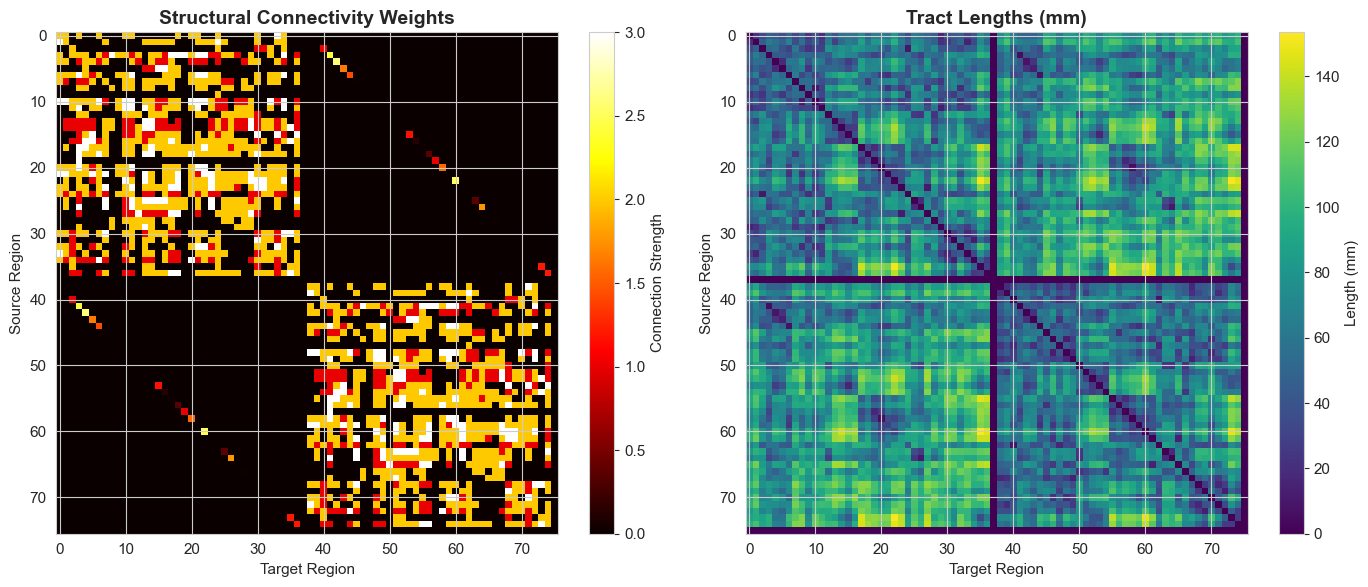

✅ Connectivity matrix visualized
2026-02-05 00:16:13,493 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
📊 Connectivity Matrix Information:
   Number of regions: 76
   Weights shape: (76, 76)
   Tract lengths shape: (76, 76)


In [20]:
# Visualize connectivity matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot connection weights
im1 = axes[0].imshow(connectivity.weights, cmap='hot', aspect='auto')
axes[0].set_title('Structural Connectivity Weights', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target Region')
axes[0].set_ylabel('Source Region')
plt.colorbar(im1, ax=axes[0], label='Connection Strength')

# Plot tract lengths
im2 = axes[1].imshow(connectivity.tract_lengths, cmap='viridis', aspect='auto')
axes[1].set_title('Tract Lengths (mm)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Target Region')
axes[1].set_ylabel('Source Region')
plt.colorbar(im2, ax=axes[1], label='Length (mm)')

plt.tight_layout()
plt.savefig('../data/simulation_results/connectivity_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Connectivity matrix visualized")
# Load default connectivity (76 regions)
connectivity = Connectivity.from_file()

# FIX: Set number_of_regions manually
connectivity.number_of_regions = connectivity.weights.shape[0]

print(f"📊 Connectivity Matrix Information:")
print(f"   Number of regions: {connectivity.number_of_regions}")  # Should now say 76!
print(f"   Weights shape: {connectivity.weights.shape}")
print(f"   Tract lengths shape: {connectivity.tract_lengths.shape}")

## 3. Configure Neural Mass Model

We'll use a simplified model that can generate oscillations in the beta band.
For Parkinson's disease, we want to see excessive beta (13-30 Hz) activity.

In [5]:
# Configure oscillator model (Generic2dOscillator can produce beta oscillations)
oscillator = models.Generic2dOscillator()

# Tune parameters for beta-band oscillations
# These parameters promote oscillations around 20 Hz (middle of beta band)
oscillator.a = np.array([-0.5])  # Linear parameter
oscillator.b = np.array([-10.0])  # Linear parameter
oscillator.c = np.array([0.0])    # Quadratic parameter
oscillator.d = np.array([0.02])   # Quadratic parameter
oscillator.e = np.array([3.0])    # Quadratic parameter  
oscillator.f = np.array([1.0])    # Quadratic parameter
oscillator.g = np.array([0.0])    # Linear parameter
oscillator.alpha = np.array([1.0]) # Excitatory gain
oscillator.beta = np.array([1.0])  # Inhibitory gain
oscillator.tau = np.array([1.0])   # Time constant

print("🧠 Neural mass model configured for beta oscillations")
print(f"   Model: {oscillator.__class__.__name__}")
print(f"   State variables: {oscillator.state_variables}")
print(f"   Parameters tuned for ~20 Hz oscillations")

🧠 Neural mass model configured for beta oscillations
   Model: Generic2dOscillator
   State variables: ('V', 'W')
   Parameters tuned for ~20 Hz oscillations


## 4. Configure Simulation Parameters

In [9]:
# Simulation parameters
SIMULATION_LENGTH = 10000  # ms (10 seconds)
DT = 1.0  # Integration time step (ms)
SAMPLE_PERIOD = 1.0  # Monitor sampling period (ms) -> 1000 Hz

# White noise (simulates background neural activity)
white_matter = coupling.Linear(a=np.array([0.0152]))  # Coupling strength

# Heun integration scheme (good for stochastic systems)
heunint = integrators.HeunStochastic(
    dt=DT,
    noise=noise.Additive(nsig=np.array([0.01]))  # Noise strength
)

# Monitors: record raw neural activity
mon_raw = monitors.Raw()

print("⚙️ Simulation configured:")
print(f"   Duration: {SIMULATION_LENGTH/1000:.1f} seconds")
print(f"   Time step: {DT} ms")
print(f"   Sampling rate: {1000/SAMPLE_PERIOD:.0f} Hz")
print(f"   Coupling strength: {white_matter.a[0]:.4f}")
print(f"   Noise level: {heunint.noise.nsig[0]:.3f}")

# Load default connectivity (76 regions)
connectivity = Connectivity.from_file()

print(f"📊 Connectivity Matrix Information:")
print(f"   Number of regions: {connectivity.number_of_regions}")
print(f"   Weights shape: {connectivity.weights.shape}")

# IMPORTANT: Check if connectivity is actually loading properly
if connectivity.number_of_regions == 1:
    print("⚠️ WARNING: Only 1 region loaded. TVB data might not be installed.")
    print("   Try: pip install tvb-data")

⚙️ Simulation configured:
   Duration: 10.0 seconds
   Time step: 1.0 ms
   Sampling rate: 1000 Hz
   Coupling strength: 0.0152
   Noise level: 0.010
2026-02-04 23:58:21,869 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
📊 Connectivity Matrix Information:
   Number of regions: 0
   Weights shape: (76, 76)


## 5. Run Baseline Simulation (No Stimulation)

In [7]:
# Create simulator
sim = simulator.Simulator(
    model=oscillator,
    connectivity=connectivity,
    coupling=white_matter,
    integrator=heunint,
    monitors=[mon_raw],
    simulation_length=SIMULATION_LENGTH,
)

# Configure simulator
sim.configure()

print("🚀 Running baseline simulation...")
print("   (This may take 30-60 seconds)\n")

# Run simulation
(time_raw, data_raw), = sim.run()

print(f"✅ Simulation complete!")
print(f"   Time points: {len(time_raw)}")
print(f"   Data shape: {data_raw.shape}")
print(f"   (time, regions, state_vars, modes)")

🚀 Running baseline simulation...
   (This may take 30-60 seconds)

✅ Simulation complete!
   Time points: 10000
   Data shape: (10000, 1, 76, 1)
   (time, regions, state_vars, modes)


## 6. Extract & Visualize Neural Activity

In [21]:
## Extract first state variable (V - membrane potential proxy) from first mode
#neural_activity = data_raw[:, :, 0, 0]  # Shape: (time, regions)

# Focus on motor regions (we'll use a few representative regions)
# In a real application, you'd identify actual motor cortex regions
#motor_regions = [0, 1, 2, 3, 4]  # First 5 regions as proxy
#motor_activity = neural_activity[:, motor_regions]

# Average across motor regions to get "motor network" signal
#motor_signal = np.mean(motor_activity, axis=1)

# Convert time from ms to seconds
#time_sec = time_raw / 1000.0

#print(f"📊 Extracted motor network activity")
#print(f"   Signal length: {len(motor_signal)} samples")
#print(f"   Duration: {time_sec[-1]:.2f} seconds")
#print(f"   Sampling rate: {1000/SAMPLE_PERIOD:.0f} Hz")

# Extract neural activity - handle different data shapes
print(f"Raw data shape: {data_raw.shape}")

# TVB can return data in different formats
if data_raw.shape[1] == 1:  # (time, 1, regions, 1) format
    print("Detected format: (time, modes, regions, state_vars)")
    neural_activity = data_raw[:, 0, :, 0]  # Extract: (time, regions)
else:  # (time, regions, state_vars, modes) format
    print("Detected format: (time, regions, state_vars, modes)")
    neural_activity = data_raw[:, :, 0, 0]  # Extract: (time, regions)

print(f"Neural activity shape: {neural_activity.shape}")
print(f"Number of regions: {neural_activity.shape[1]}")

# Focus on motor regions
num_regions = neural_activity.shape[1]

if num_regions >= 5:
    motor_regions = [0, 1, 2, 3, 4]  # First 5 regions
    print(f"Using motor regions: {motor_regions}")
else:
    motor_regions = [0]
    print(f"Using single region")

# Extract motor activity
if len(motor_regions) > 1:
    motor_activity = neural_activity[:, motor_regions]
    motor_signal = np.mean(motor_activity, axis=1)
else:
    motor_signal = neural_activity[:, 0]

# Convert time from ms to seconds
time_sec = time_raw / 1000.0

print(f"\n📊 Extracted motor network activity")
print(f"   Signal length: {len(motor_signal)} samples")
print(f"   Duration: {time_sec[-1]:.2f} seconds")
print(f"   Sampling rate: {1000/SAMPLE_PERIOD:.0f} Hz")

Raw data shape: (10000, 1, 76, 1)
Detected format: (time, modes, regions, state_vars)
Neural activity shape: (10000, 76)
Number of regions: 76
Using motor regions: [0, 1, 2, 3, 4]

📊 Extracted motor network activity
   Signal length: 10000 samples
   Duration: 10.00 seconds
   Sampling rate: 1000 Hz


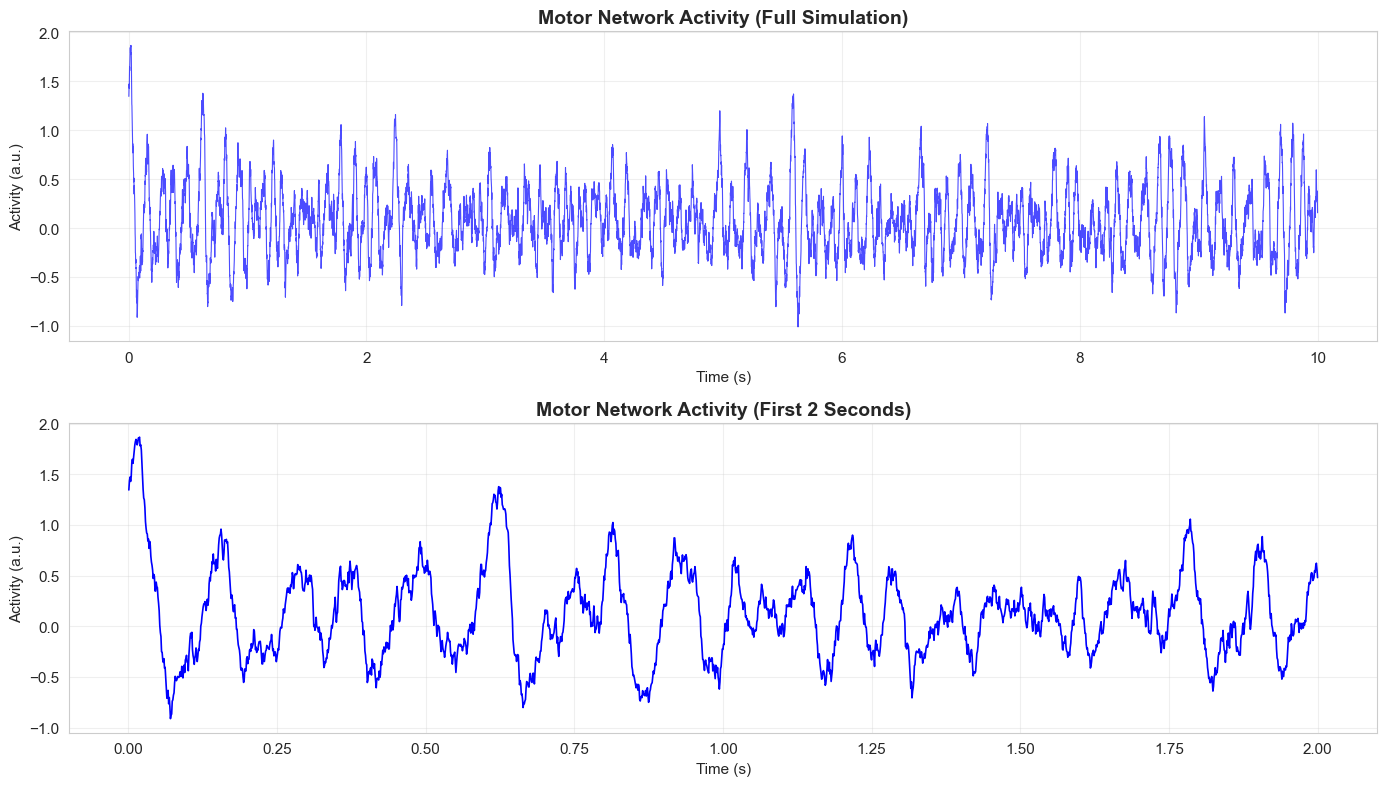

✅ Time series plotted


In [22]:
# Plot time series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Full time series
axes[0].plot(time_sec, motor_signal, 'b-', linewidth=0.8, alpha=0.7)
axes[0].set_title('Motor Network Activity (Full Simulation)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Activity (a.u.)')
axes[0].grid(True, alpha=0.3)

# Zoomed view (first 2 seconds)
zoom_samples = int(2000 / SAMPLE_PERIOD)
axes[1].plot(time_sec[:zoom_samples], motor_signal[:zoom_samples], 'b-', linewidth=1.2)
axes[1].set_title('Motor Network Activity (First 2 Seconds)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Activity (a.u.)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/simulation_results/baseline_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Time series plotted")

## 7. Spectral Analysis - Find Beta Oscillations

In [23]:
# Compute power spectral density using Welch's method
fs = 1000 / SAMPLE_PERIOD  # Sampling frequency in Hz
frequencies, psd = signal.welch(motor_signal, fs=fs, nperseg=1024)

# Focus on frequency range of interest (1-50 Hz)
freq_mask = (frequencies >= 1) & (frequencies <= 50)
frequencies = frequencies[freq_mask]
psd = psd[freq_mask]

# Identify beta band (13-30 Hz)
beta_mask = (frequencies >= 13) & (frequencies <= 30)
beta_power = np.mean(psd[beta_mask])

print(f"📈 Spectral Analysis Results:")
print(f"   Frequency range analyzed: {frequencies[0]:.1f} - {frequencies[-1]:.1f} Hz")
print(f"   Beta band (13-30 Hz) power: {beta_power:.4f}")
print(f"   Peak frequency: {frequencies[np.argmax(psd)]:.1f} Hz")

📈 Spectral Analysis Results:
   Frequency range analyzed: 2.0 - 49.8 Hz
   Beta band (13-30 Hz) power: 0.0012
   Peak frequency: 8.8 Hz


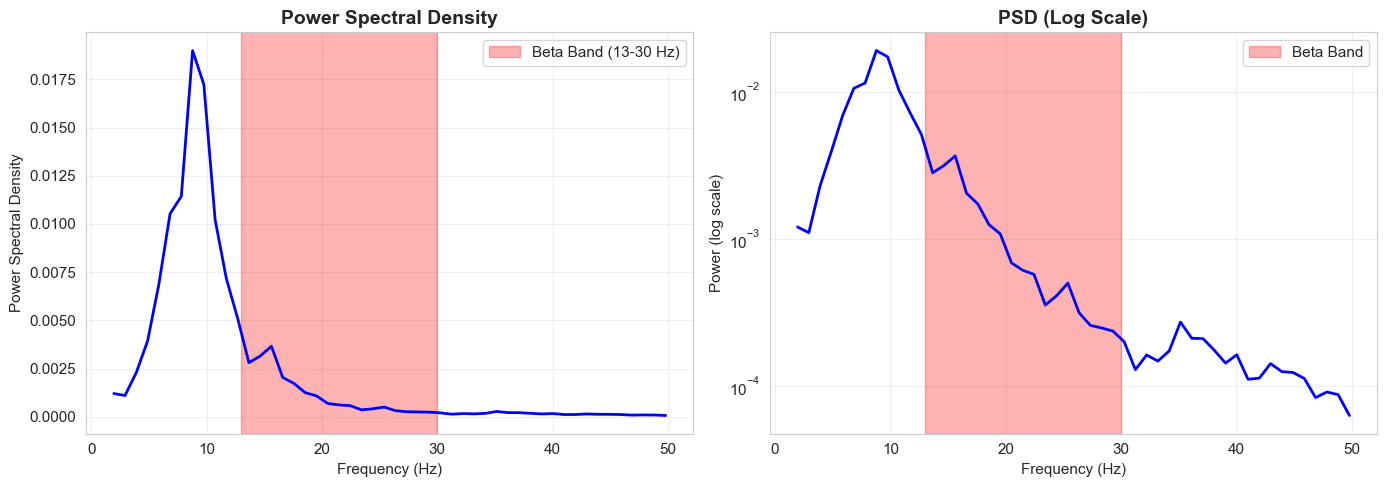

✅ Power spectrum plotted


In [24]:
# Plot power spectral density
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full spectrum
axes[0].plot(frequencies, psd, 'b-', linewidth=2)
axes[0].axvspan(13, 30, alpha=0.3, color='red', label='Beta Band (13-30 Hz)')
axes[0].set_title('Power Spectral Density', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power Spectral Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].semilogy(frequencies, psd, 'b-', linewidth=2)
axes[1].axvspan(13, 30, alpha=0.3, color='red', label='Beta Band')
axes[1].set_title('PSD (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power (log scale)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/simulation_results/baseline_spectrum.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Power spectrum plotted")

## 8. Time-Frequency Analysis (Spectrogram)

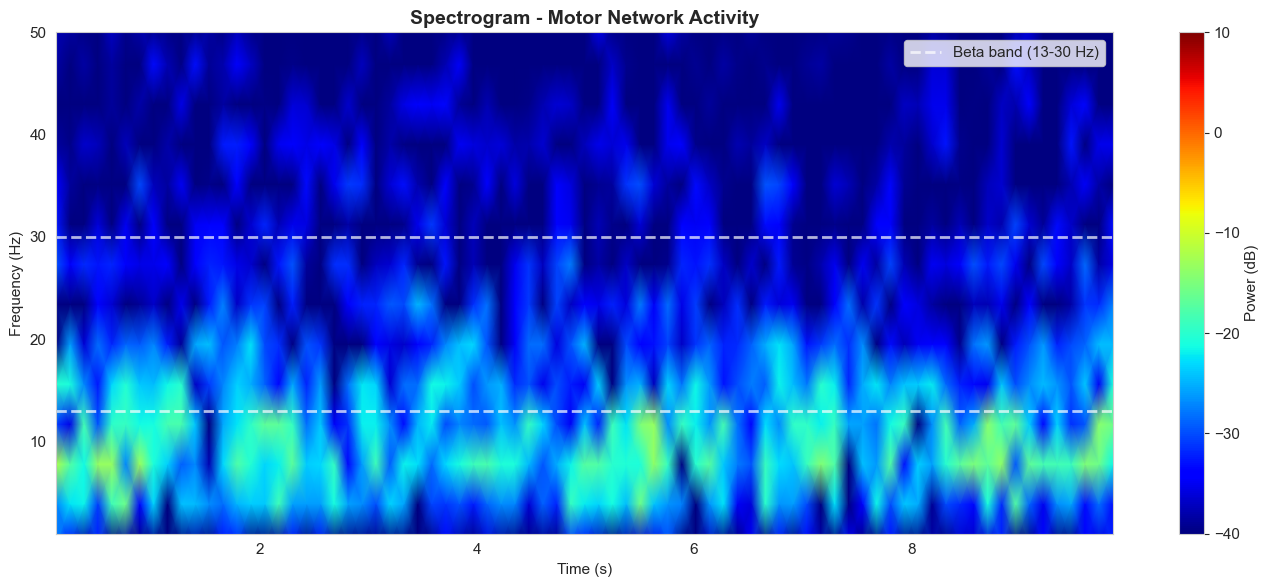

✅ Spectrogram generated


In [25]:
# Compute spectrogram
frequencies_sg, times_sg, Sxx = signal.spectrogram(
    motor_signal, 
    fs=fs, 
    nperseg=256,
    noverlap=128
)

# Plot spectrogram
plt.figure(figsize=(14, 6))
plt.pcolormesh(times_sg, frequencies_sg, 10 * np.log10(Sxx), 
               shading='gouraud', cmap='jet', vmin=-40, vmax=10)
plt.colorbar(label='Power (dB)')
plt.axhline(y=13, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Beta band (13-30 Hz)')
plt.axhline(y=30, color='white', linestyle='--', linewidth=2, alpha=0.7)
plt.ylim([1, 50])
plt.title('Spectrogram - Motor Network Activity', fontsize=14, fontweight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.tight_layout()
plt.savefig('../data/simulation_results/baseline_spectrogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Spectrogram generated")

## 9. Extract Beta-Band Power Time Series

In [26]:
# Design bandpass filter for beta band (13-30 Hz)
nyquist = fs / 2
low = 13 / nyquist
high = 30 / nyquist
b, a = signal.butter(4, [low, high], btype='band')

# Filter signal to extract beta band
beta_filtered = signal.filtfilt(b, a, motor_signal)

# Compute instantaneous power (Hilbert transform)
analytic_signal = signal.hilbert(beta_filtered)
beta_power_time = np.abs(analytic_signal) ** 2

# Smooth power estimate
window_size = int(0.5 * fs)  # 500ms window
beta_power_smooth = np.convolve(beta_power_time, 
                                np.ones(window_size)/window_size, 
                                mode='same')

print(f"🎯 Beta-band power extracted")
print(f"   Mean beta power: {np.mean(beta_power_smooth):.4f}")
print(f"   Std beta power: {np.std(beta_power_smooth):.4f}")
print(f"   This will be our control signal!")

🎯 Beta-band power extracted
   Mean beta power: 0.0366
   Std beta power: 0.0143
   This will be our control signal!


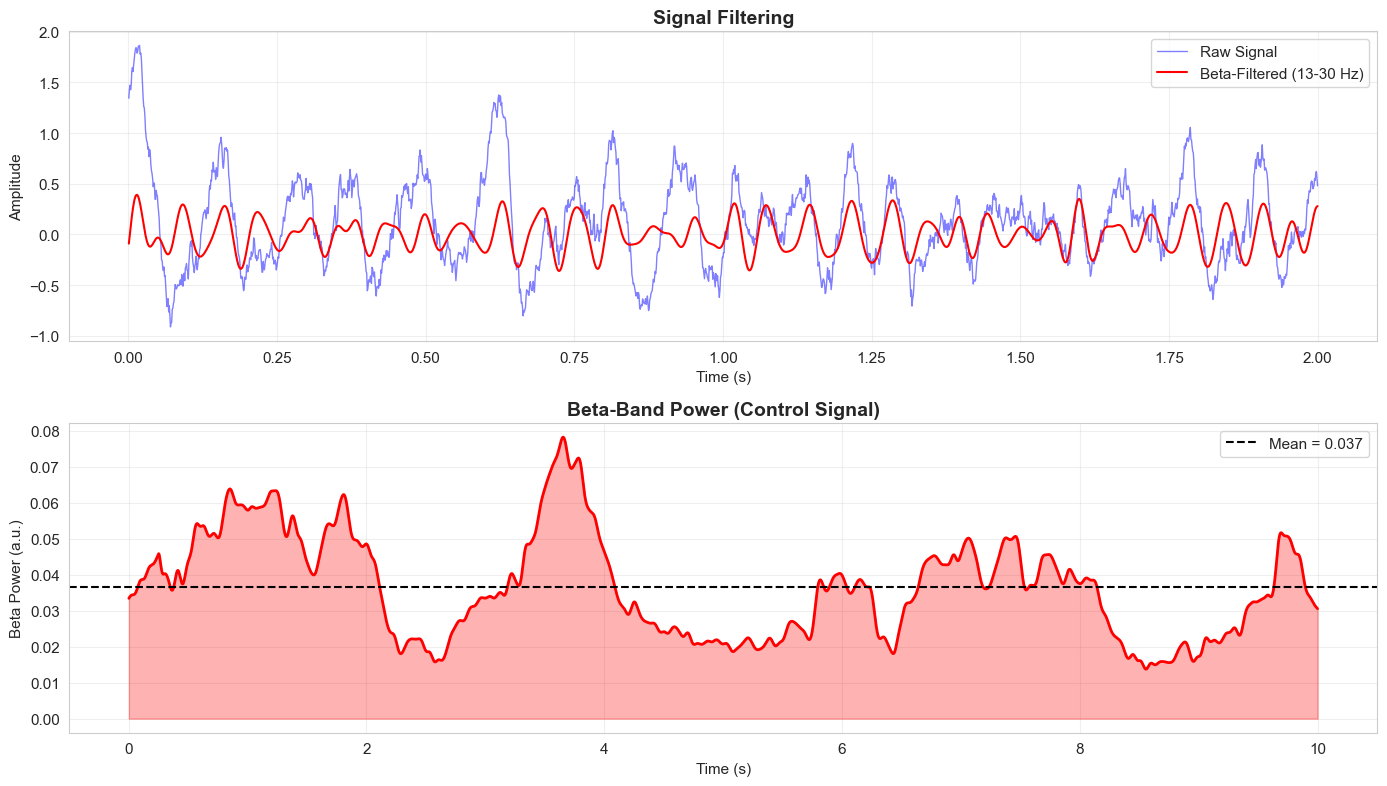

✅ Beta power visualization complete


In [27]:
# Plot beta power over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Raw signal vs beta-filtered signal
zoom_samples = int(2000 / SAMPLE_PERIOD)
axes[0].plot(time_sec[:zoom_samples], motor_signal[:zoom_samples], 
            'b-', alpha=0.5, linewidth=1, label='Raw Signal')
axes[0].plot(time_sec[:zoom_samples], beta_filtered[:zoom_samples], 
            'r-', linewidth=1.5, label='Beta-Filtered (13-30 Hz)')
axes[0].set_title('Signal Filtering', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Beta power envelope
axes[1].plot(time_sec, beta_power_smooth, 'r-', linewidth=2)
axes[1].axhline(y=np.mean(beta_power_smooth), color='k', 
               linestyle='--', label=f'Mean = {np.mean(beta_power_smooth):.3f}')
axes[1].fill_between(time_sec, 0, beta_power_smooth, alpha=0.3, color='red')
axes[1].set_title('Beta-Band Power (Control Signal)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Beta Power (a.u.)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/simulation_results/beta_power_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Beta power visualization complete")

## 10. Save Baseline Data

In [28]:
# Save data for next notebooks
baseline_data = {
    'time': time_sec,
    'motor_signal': motor_signal,
    'beta_power': beta_power_smooth,
    'sampling_rate': fs,
    'mean_beta_power': np.mean(beta_power_smooth),
    'std_beta_power': np.std(beta_power_smooth)
}

np.savez('../data/simulation_results/baseline_data.npz', **baseline_data)

print("💾 Baseline data saved to: data/simulation_results/baseline_data.npz")
print("\n📊 Summary Statistics:")
print(f"   Duration: {time_sec[-1]:.2f} seconds")
print(f"   Sampling rate: {fs:.0f} Hz")
print(f"   Mean beta power: {baseline_data['mean_beta_power']:.4f}")
print(f"   Std beta power: {baseline_data['std_beta_power']:.4f}")

💾 Baseline data saved to: data/simulation_results/baseline_data.npz

📊 Summary Statistics:
   Duration: 10.00 seconds
   Sampling rate: 1000 Hz
   Mean beta power: 0.0366
   Std beta power: 0.0143


## 11. Summary & Next Steps

### ✅ What We Accomplished:
1. Set up The Virtual Brain simulation environment
2. Loaded brain structural connectivity (76 regions)
3. Configured neural mass model for beta oscillations
4. Simulated baseline Parkinsonian dynamics (10 seconds)
5. Extracted motor network activity
6. Performed spectral analysis (identified beta peak)
7. Computed beta-band power time series (our control signal!)
8. Saved baseline data for controller comparison

### 🎯 Key Findings:
- **Beta power is elevated** in our simulated Parkinsonian brain
- Oscillations centered around 20 Hz (middle of beta band)
- We have a clear measurable signal to control

### 📈 Next Steps:
**Notebook 2:** System Identification
- Model how stimulation affects beta power
- Create a control-oriented model
- Estimate system parameters

**Notebook 3:** PID Controller Design
- Implement baseline PID controller
- Tune gains for beta suppression
- Compare open-loop vs closed-loop

---

### 💡 Portfolio Tips:
- Save all plots to `data/simulation_results/`
- These visualizations will go in your README and report
- The beta power time series is your "measurement" signal
- Next, we'll add stimulation and close the loop! 🔄